In [1]:
!pip install yahoo_fin

     |████████████████████████████████| 81 kB 4.2 MB/s 
     |████████████████████████████████| 83 kB 1.7 MB/s 
     |████████████████████████████████| 103 kB 27.7 MB/s 
     |████████████████████████████████| 127 kB 46.7 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=a4e627f4fe4a9fa17fc2a01b346668f05037862bf6aadf860fabfaf7aaf86540
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=63a420945ce7ec36875c7e8404eeef5429a74a17465613e4fd018cf324860ed5
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=a2eb3aa94e2eefedce6e74f791e866e1028771bc639cb8fe7bd2f612112a2f21
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36ce

In [2]:
import yahoo_fin.stock_info as si
import datetime
from dateutil import rrule
from dateutil import relativedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [4]:
#Hyperparameters
time_step = 10
num_features = 1
epochs = 100
batch_size = 64
invest = 10000

In [4]:
#Download data from yahoo finance
def get_data(_ticker):
  df = si.get_data(_ticker)
  close = (df['close']).values.reshape(-1, 1)
  close_date = np.array(df.index.to_pydatetime()).reshape(-1, 1)
  return close, close_date

In [5]:
aapl_close, aapl_close_date = get_data("AAPL")
dis_close, dis_close_date = get_data("DIS")
f_close, f_close_date = get_data("F")
jpm_close, jpm_close_date = get_data("JPM")
mmm_close, mmm_close_date = get_data("MMM")
sp_close, sp_close_date = get_data("^GSPC")

In [6]:
#Get friday dates for testing range
def test_dates(_start_year):
  start_year = _start_year
  start_date = datetime.datetime(start_year, 1, 1)
  end_date = datetime.datetime.today()
  rr = rrule.rrule(rrule.WEEKLY, byweekday=relativedelta.FR, dtstart=start_date)
  fridays = np.array(rr.between(start_date, end_date, inc=True)).reshape(-1, 1)
  return fridays

In [7]:
test_fridays = test_dates(2020)

In [8]:
#Apply Min/Max Scaler to data
def scaler(_data):
  sc = MinMaxScaler(feature_range=(0, 1))
  data_scaled = sc.fit_transform(_data)
  return sc, data_scaled

In [9]:
aapl_sc, aapl_close_scaled = scaler(aapl_close)
dis_sc, dis_close_scaled = scaler(dis_close)
f_sc, f_close_scaled = scaler(f_close)
jpm_sc, jpm_close_scaled = scaler(jpm_close)
mmm_sc, mmm_close_scaled = scaler(mmm_close)
sp_sc, sp_close_scaled = scaler(sp_close)

In [10]:
#Create date stamped array of data
def date_array(_close_date, _close_scaled):
  features_scaled = np.array([_close_date, _close_scaled]).T
  features_scaled = np.reshape(features_scaled, 
                                  (np.shape(features_scaled)[1], 
                                   np.shape(features_scaled)[2]))
  return features_scaled

In [11]:
aapl_features_scaled = date_array(aapl_close_date, aapl_close_scaled)
dis_features_scaled = date_array(dis_close_date, dis_close_scaled)
f_features_scaled = date_array(f_close_date, f_close_scaled)
jpm_features_scaled = date_array(jpm_close_date, jpm_close_scaled)
mmm_features_scaled = date_array(mmm_close_date, mmm_close_scaled)
sp_features_scaled = date_array(sp_close_date, sp_close_scaled)

In [12]:
#Create train and testing data
def train_test_data(_features_scaled, _sc, _test_dates, _time_step, _num_features):
  X = []
  y = []
  for i in range(len(_features_scaled)-_time_step-4):
    X.append(_features_scaled[i:i+_time_step])
    y.append(_features_scaled[i+_time_step+4])
  X = np.array(X)
  y = np.array(y)
  X_train_dates = X[:int(np.where(y[:, 0]==_test_dates[0])[0])]
  X_train = np.array(X_train_dates[:, :, 1].reshape(len(X_train_dates), 
                                                            _time_step, _num_features), dtype='f')
  y_train_dates = y[:int(np.where(y[:, 0]==_test_dates[0])[0])]
  y_train = np.array(y_train_dates[:, 1].reshape(-1, 1), dtype='f')
  X_test_dates = X[np.where(y[:, 0]==_test_dates)[1]]
  X_test = np.array(X_test_dates[:, :, 1].reshape(len(X_test_dates), 
                                                          _time_step, _num_features), dtype='f')
  y_test_dates = y[np.where(y[:, 0]==_test_dates)[1]]
  y_test = _sc.inverse_transform(np.array(y_test_dates[:, 1].reshape(-1, 1), dtype='f'))
  return X_train, y_train, X_test, y_test, y_test_dates

In [13]:
X_aapl_train, y_aapl_train, X_aapl_test, y_aapl_test, y_aapl_test_dates = train_test_data(aapl_features_scaled, aapl_sc,
                                                                                          test_fridays, time_step, num_features)
X_dis_train, y_dis_train, X_dis_test, y_dis_test, y_dis_test_dates = train_test_data(dis_features_scaled, dis_sc,
                                                                                          test_fridays, time_step, num_features)
X_f_train, y_f_train, X_f_test, y_f_test, y_f_test_dates = train_test_data(f_features_scaled, f_sc,
                                                                                          test_fridays, time_step, num_features)
X_jpm_train, y_jpm_train, X_jpm_test, y_jpm_test, y_jpm_test_dates = train_test_data(jpm_features_scaled, jpm_sc,
                                                                                          test_fridays, time_step, num_features)
X_mmm_train, y_mmm_train, X_mmm_test, y_mmm_test, y_mmm_test_dates = train_test_data(mmm_features_scaled, mmm_sc,
                                                                                          test_fridays, time_step, num_features)
X_sp_train, y_sp_train, X_sp_test, y_sp_test, y_sp_test_dates = train_test_data(sp_features_scaled, sp_sc,
                                                                                          test_fridays, time_step, num_features)

In [17]:
#Train model and predict close prices
def model(_X_train, _y_train, _X_test, _sc, _epochs, _batch_size):
  regressor = Sequential()
  regressor.add(Conv1D(64, 2, padding='causal', strides=1, activation='relu', input_shape=(None, num_features)))
  regressor.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
  regressor.add(Conv1D(64, 2, padding='causal', strides=1, activation='relu'))
  regressor.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
  regressor.add(LSTM(units=64))
  regressor.add(Dense(units=32))
  regressor.add(Dense(units=1))
  regressor.compile(optimizer='adam', loss='mean_absolute_error')
  history = regressor.fit(_X_train, _y_train, epochs=_epochs, batch_size=_batch_size)
  y_hat = _sc.inverse_transform(regressor.predict(_X_test))
  return history, y_hat

In [287]:
aapl_history, y_aapl_hat = model(X_aapl_train, y_aapl_train, X_aapl_test, aapl_sc, epochs, batch_size)

Epoch 1/100
154/154 [==============================] - 4s 14ms/step - loss: 0.0050
Epoch 2/100
154/154 [==============================] - 2s 13ms/step - loss: 0.0029
Epoch 3/100
154/154 [==============================] - 2s 14ms/step - loss: 0.0027
Epoch 4/100
154/154 [==============================] - 2s 13ms/step - loss: 0.0026
Epoch 5/100
154/154 [==============================] - 2s 14ms/step - loss: 0.0025
Epoch 6/100
154/154 [==============================] - 2s 13ms/step - loss: 0.0024
Epoch 7/100
154/154 [==============================] - 2s 13ms/step - loss: 0.0023
Epoch 8/100
154/154 [==============================] - 2s 13ms/step - loss: 0.0024
Epoch 9/100
154/154 [==============================] - 2s 13ms/step - loss: 0.0023
Epoch 10/100
154/154 [==============================] - 2s 13ms/step - loss: 0.0024
Epoch 11/100
154/154 [==============================] - 2s 13ms/step - loss: 0.0022
Epoch 12/100
154/154 [==============================] - 2s 13ms/step - loss: 0.0024
E

In [342]:
dis_history, y_dis_hat = model(X_dis_train, y_dis_train, X_dis_test, dis_sc, epochs, batch_size)

Epoch 1/100
196/196 [==============================] - 4s 13ms/step - loss: 0.0094
Epoch 2/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0051
Epoch 3/100
196/196 [==============================] - 2s 13ms/step - loss: 0.0045
Epoch 4/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0045
Epoch 5/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0042
Epoch 6/100
196/196 [==============================] - 2s 13ms/step - loss: 0.0042
Epoch 7/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0043
Epoch 8/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0046
Epoch 9/100
196/196 [==============================] - 2s 13ms/step - loss: 0.0041
Epoch 10/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0041
Epoch 11/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0041
Epoch 12/100
196/196 [==============================] - 2s 13ms/step - loss: 0.0041
E

In [322]:
f_history, y_f_hat = model(X_f_train, y_f_train, X_f_test, f_sc, epochs, batch_size)

Epoch 1/100
188/188 [==============================] - 4s 12ms/step - loss: 0.0200
Epoch 2/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0109
Epoch 3/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0104
Epoch 4/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0103
Epoch 5/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0104
Epoch 6/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0101
Epoch 7/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0099
Epoch 8/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0101
Epoch 9/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0096
Epoch 10/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0098
Epoch 11/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0098
Epoch 12/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0099
E

In [325]:
jpm_history, y_jpm_hat = model(X_jpm_train, y_jpm_train, X_jpm_test, jpm_sc, epochs, batch_size)

Epoch 1/100
157/157 [==============================] - 4s 12ms/step - loss: 0.0153
Epoch 2/100
157/157 [==============================] - 2s 12ms/step - loss: 0.0080
Epoch 3/100
157/157 [==============================] - 2s 13ms/step - loss: 0.0081
Epoch 4/100
157/157 [==============================] - 2s 13ms/step - loss: 0.0079
Epoch 5/100
157/157 [==============================] - 2s 12ms/step - loss: 0.0075
Epoch 6/100
157/157 [==============================] - 2s 12ms/step - loss: 0.0073
Epoch 7/100
157/157 [==============================] - 2s 13ms/step - loss: 0.0072
Epoch 8/100
157/157 [==============================] - 2s 12ms/step - loss: 0.0073
Epoch 9/100
157/157 [==============================] - 2s 13ms/step - loss: 0.0071
Epoch 10/100
157/157 [==============================] - 2s 12ms/step - loss: 0.0070
Epoch 11/100
157/157 [==============================] - 2s 13ms/step - loss: 0.0070
Epoch 12/100
157/157 [==============================] - 2s 13ms/step - loss: 0.0071
E

In [353]:
mmm_history, y_mmm_hat = model(X_mmm_train, y_mmm_train, X_mmm_test, mmm_sc, epochs, batch_size)

Epoch 1/100
196/196 [==============================] - 4s 12ms/step - loss: 0.0120
Epoch 2/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0059
Epoch 3/100
196/196 [==============================] - 3s 13ms/step - loss: 0.0059
Epoch 4/100
196/196 [==============================] - 2s 13ms/step - loss: 0.0060
Epoch 5/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0057
Epoch 6/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0060
Epoch 7/100
196/196 [==============================] - 3s 13ms/step - loss: 0.0060
Epoch 8/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0058
Epoch 9/100
196/196 [==============================] - 2s 13ms/step - loss: 0.0055
Epoch 10/100
196/196 [==============================] - 2s 13ms/step - loss: 0.0054
Epoch 11/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0058
Epoch 12/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0057
E

In [268]:
#Plot and save loss curve
def loss_curve(_history, _ticker):
  plt.plot(_history.history['loss'], label='Training Loss')
  plt.title(_ticker + ' Stock Price Prediction Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.savefig(_ticker + '_Loss_Curve.png', dpi=300, bbox_inches = 'tight')
  plt.show()

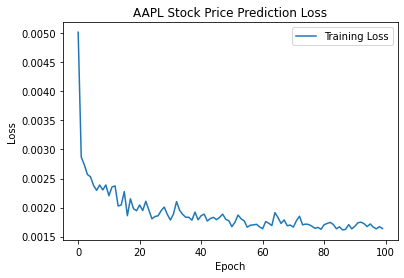

In [356]:
loss_curve(aapl_history, 'AAPL')

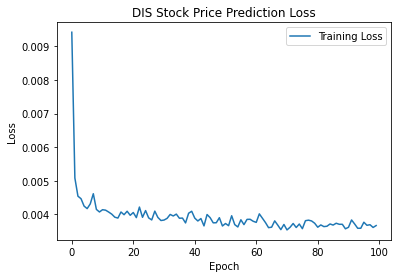

In [357]:
loss_curve(dis_history, 'DIS')

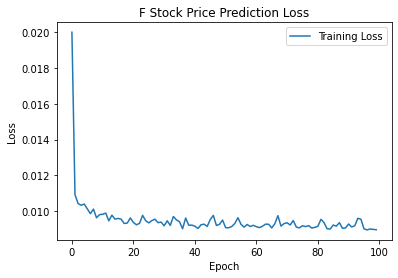

In [358]:
loss_curve(f_history, 'F')

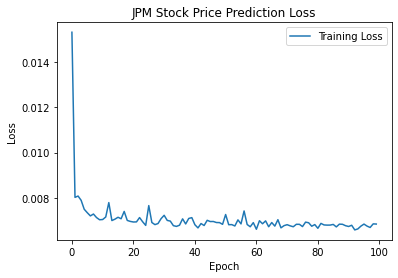

In [359]:
loss_curve(jpm_history, 'JPM')

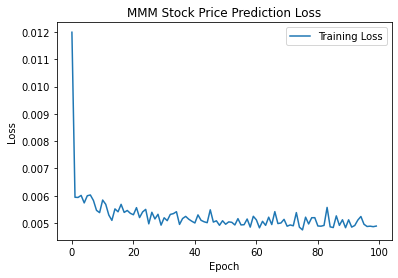

In [360]:
loss_curve(mmm_history, 'MMM')

In [274]:
#Plot predicted close prices vs actual close prices
def close_prices_plt(_y_test_dates, _y_test, _y_hat, _ticker):
  plt.plot(_y_test_dates[:, 0], _y_test, color='red', label='Real ' + _ticker + ' Stock Price')
  plt.plot(_y_test_dates[:, 0], _y_hat, color='blue', label='Predicted ' + _ticker + ' Stock Price')
  plt.title(_ticker + ' Stock Price Prediction')
  plt.xlabel('Date')
  plt.xticks(rotation = 45)
  plt.ylabel('Stock Close Price')
  plt.legend(loc='lower right')
  plt.savefig(_ticker + '_Close_Prices.png', dpi=300, bbox_inches = 'tight')
  plt.show()

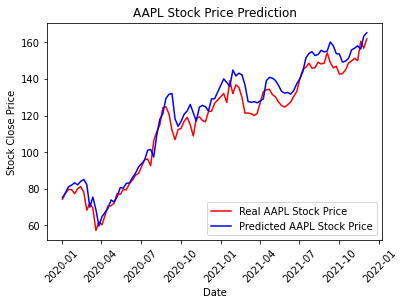

In [361]:
close_prices_plt(y_aapl_test_dates, y_aapl_test, y_aapl_hat, 'AAPL')

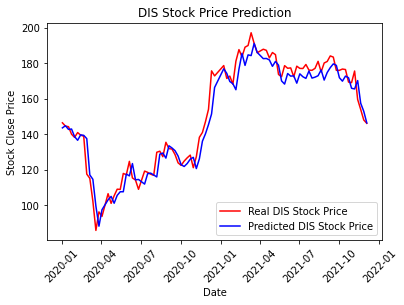

In [362]:
close_prices_plt(y_dis_test_dates, y_dis_test, y_dis_hat, 'DIS')

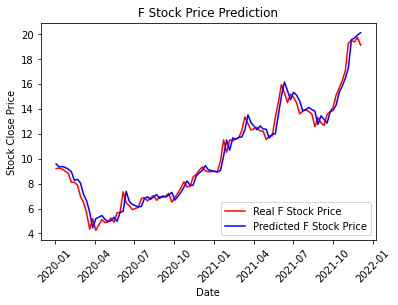

In [363]:
close_prices_plt(y_f_test_dates, y_f_test, y_f_hat, 'F')

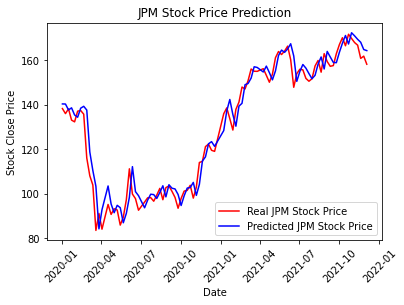

In [364]:
close_prices_plt(y_jpm_test_dates, y_jpm_test, y_jpm_hat, 'JPM')

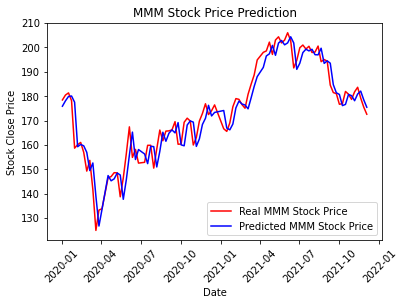

In [365]:
close_prices_plt(y_mmm_test_dates, y_mmm_test, y_mmm_hat, 'MMM')

In [280]:
def single_stock_analyis(_y_hat, _y_test_dates, _y_test, _sc, _y_sp_test_dates, _sp_sc, _invest, _ticker):
  pred_inc = []
  for i in range(1,len(_y_hat)):
    pred_inc.append([_y_test_dates[i, 0], ((_y_hat[i] - _y_test[i-1])/_y_test[i-1])*100])
  pred_inc = np.array(pred_inc, dtype='object')

  act_inc = []
  for i in range(1,len(_y_test)):
    act_inc.append([_y_test_dates[i, 0], ((_y_test[i] - _y_test[i-1])/_y_test[i-1])*100])
  act_inc = np.array(act_inc, dtype='object')

  pred_sign = np.sign(pred_inc[:, 1])
  act_sign = np.sign(act_inc[:, 1])
  misclass = 0
  for i in range(len(pred_inc)):
    if pred_sign[i] != act_sign[i]:
      misclass += 1
  print('Error rate of predicted weekly gains:', misclass/len(pred_inc))

  sp_hold_invest = invest
  sp_hold_gains = []
  sp_hold_gains.append(sp_hold_invest)
  for i in range(len(_y_test_dates)-1):
      buy_price = _sp_sc.inverse_transform(_y_sp_test_dates[_y_sp_test_dates[:, 0]==_y_sp_test_dates[i, 0]][:, 1].reshape(-1, 1))
      sell_price = _sp_sc.inverse_transform(_y_sp_test_dates[_y_sp_test_dates[:, 0]==_y_sp_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
      sp_hold_invest = ((((sell_price - buy_price)/buy_price)*sp_hold_invest)+sp_hold_invest)
      sp_hold_gains.append(sp_hold_invest)
  sp_hold_gains = np.array(sp_hold_gains, dtype='object').reshape(len(sp_hold_gains))
  print('Total S&P gains if held for the whole duration:', float(sp_hold_invest))

  hold_invest = invest
  hold_gains = []
  hold_gains.append(hold_invest)
  for i in range(len(_y_test_dates)-1):
      buy_price = _sc.inverse_transform(_y_test_dates[_y_test_dates[:, 0]==_y_test_dates[i, 0]][:, 1].reshape(-1, 1))
      sell_price = _sc.inverse_transform(_y_test_dates[_y_test_dates[:, 0]==_y_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
      hold_invest = ((((sell_price - buy_price)/buy_price)*hold_invest)+hold_invest)
      hold_gains.append(hold_invest)
  hold_gains = np.array(hold_gains, dtype='object').reshape(len(hold_gains))
  print('Total ' + _ticker + ' gains if held for the whole duration:', float(hold_invest))

  model_invest = invest
  model_gains = []
  model_gains.append(model_invest)
  for i in range(len(_y_test_dates)-1):
    if float(pred_inc[i, 1]) > 0:
      buy_price = _sc.inverse_transform(_y_test_dates[_y_test_dates[:, 0]==_y_test_dates[i, 0]][:, 1].reshape(-1, 1))
      sell_price = _sc.inverse_transform(_y_test_dates[_y_test_dates[:, 0]==_y_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
      model_invest = ((((sell_price - buy_price)/buy_price)*model_invest)+model_invest)
      model_gains.append(model_invest)
    else:
      model_gains.append(model_invest)
  model_gains = np.array(model_gains, dtype='object').reshape(len(model_gains))
  print('Total ' + _ticker + ' gains using model to invest:', float(model_invest))

  model_sp_invest = invest
  model_sp_gains = []
  model_sp_gains.append(model_sp_invest)
  for i in range(len(_y_test_dates)-1):
    if float(pred_inc[i, 1]) > 0.:
      buy_price = _sc.inverse_transform(_y_test_dates[_y_test_dates[:, 0]==_y_test_dates[i, 0]][:, 1].reshape(-1, 1))
      sell_price = _sc.inverse_transform(_y_test_dates[_y_test_dates[:, 0]==_y_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
      model_sp_invest = ((((sell_price - buy_price)/buy_price)*model_sp_invest)+model_sp_invest)
      model_sp_gains.append(model_sp_invest)
    else:
      buy_price = _sp_sc.inverse_transform(_y_sp_test_dates[_y_sp_test_dates[:, 0]==_y_sp_test_dates[i, 0]][:, 1].reshape(-1, 1))
      sell_price = _sp_sc.inverse_transform(_y_sp_test_dates[_y_sp_test_dates[:,0]==_y_sp_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
      model_sp_invest = ((((sell_price - buy_price)/buy_price)*model_sp_invest)+model_sp_invest)
      model_sp_gains.append(model_sp_invest)
  model_sp_gains = np.array(model_sp_gains, dtype='object').reshape(len(model_sp_gains))
  print('Total ' + _ticker + ' gains using model and S&P to invest:', float(model_sp_invest))

  plt.plot(_y_test_dates[:, 0], sp_hold_gains, color='yellow', label='S&P Hold Gains')
  plt.plot(_y_test_dates[:, 0], hold_gains, color='red', label=_ticker + ' Hold Gains')
  plt.plot(_y_test_dates[:, 0], model_gains, color='green', label=_ticker + ' Model Gains')
  plt.plot(_y_test_dates[:, 0], model_sp_gains, color='blue', label=_ticker + ' Model + S&P Gains')
  plt.title(_ticker + ' Portfolio Value')
  plt.xlabel('Date')
  plt.xticks(rotation = 45)
  plt.ylabel('Portfolio Value')
  plt.legend(loc='upper left')
  plt.savefig(_ticker + '_Portfolio_Value.png', dpi=300, bbox_inches = 'tight')
  plt.show()

  return pred_inc

Error rate of predicted weekly gains: 0.3684210526315789
Total S&P gains if held for the whole duration: 14029.800574281577
Total AAPL gains if held for the whole duration: 21765.12124845556
Total AAPL gains using model to invest: 26391.77558466058
Total AAPL gains using model and S&P to invest: 22438.39177892029


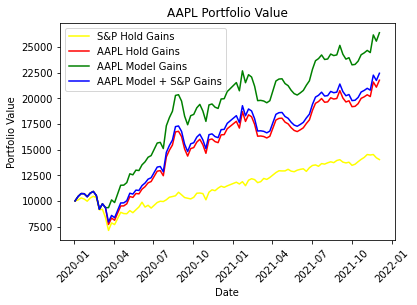

In [366]:
aapl_pred_inc = single_stock_analyis(y_aapl_hat, y_aapl_test_dates, y_aapl_test, aapl_sc, y_sp_test_dates, sp_sc, invest, 'AAPL')

Error rate of predicted weekly gains: 0.4
Total S&P gains if held for the whole duration: 14029.800574281577
Total DIS gains if held for the whole duration: 9980.887455338097
Total DIS gains using model to invest: 14404.483533111024
Total DIS gains using model and S&P to invest: 15180.68779144455


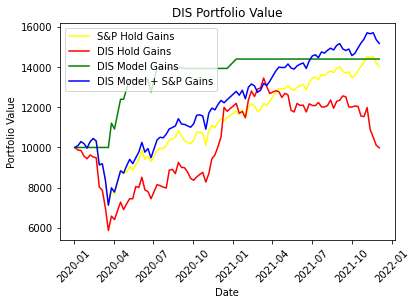

In [367]:
dis_pred_inc = single_stock_analyis(y_dis_hat, y_dis_test_dates, y_dis_test, dis_sc, y_sp_test_dates, sp_sc, invest, 'DIS')

Error rate of predicted weekly gains: 0.4421052631578947
Total S&P gains if held for the whole duration: 14029.800574281577
Total F gains if held for the whole duration: 20781.758208873318
Total F gains using model to invest: 26934.286603207773
Total F gains using model and S&P to invest: 26732.589854249065


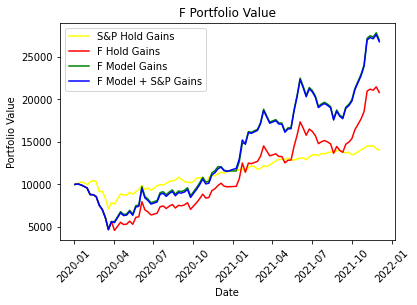

In [368]:
f_pred_inc = single_stock_analyis(y_f_hat, y_f_test_dates, y_f_test, f_sc, y_sp_test_dates, sp_sc, invest, 'F')

Error rate of predicted weekly gains: 0.47368421052631576
Total S&P gains if held for the whole duration: 14029.800574281577
Total JPM gains if held for the whole duration: 11442.098993519925
Total JPM gains using model to invest: 13811.059649348284
Total JPM gains using model and S&P to invest: 11806.897587520989


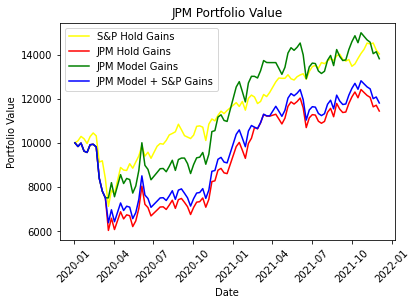

In [369]:
jpm_pred_inc = single_stock_analyis(y_jpm_hat, y_jpm_test_dates, y_jpm_test, jpm_sc, y_sp_test_dates, sp_sc, invest, 'JPM')

Error rate of predicted weekly gains: 0.5263157894736842
Total S&P gains if held for the whole duration: 14029.800574281577
Total MMM gains if held for the whole duration: 9671.616659536778
Total MMM gains using model to invest: 12288.615934849015
Total MMM gains using model and S&P to invest: 14030.932474577372


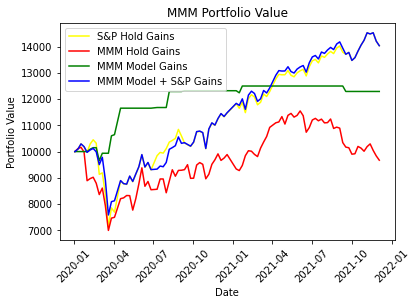

In [370]:
mmm_pred_inc = single_stock_analyis(y_mmm_hat, y_mmm_test_dates, y_mmm_test, mmm_sc, y_sp_test_dates, sp_sc, invest, 'MMM')

Total S&P gains if held for the whole duration: 14029.800574281577
Total gains using model to invest: 19176.308327359435


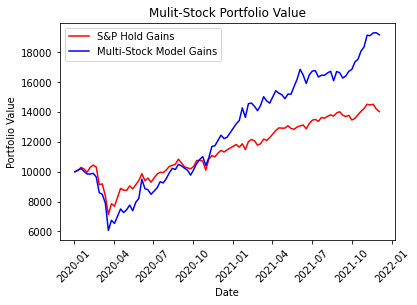

In [371]:
sp_hold_invest = invest
sp_hold_gains = []
sp_hold_gains.append(sp_hold_invest)
for i in range(len(aapl_pred_inc)):
  sp_buy_price = sp_sc.inverse_transform(y_sp_test_dates[y_sp_test_dates[:, 0]==y_sp_test_dates[i, 0]][:, 1].reshape(-1, 1))
  sp_sell_price = sp_sc.inverse_transform(y_sp_test_dates[y_sp_test_dates[:, 0]==y_sp_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
  sp_hold_invest = ((((sp_sell_price - sp_buy_price)/sp_buy_price)*sp_hold_invest)+sp_hold_invest)
  sp_hold_gains.append(sp_hold_invest)
sp_hold_gains = np.array(sp_hold_gains, dtype='object').reshape(len(sp_hold_gains))
print('Total S&P gains if held for the whole duration:', float(sp_hold_invest))

model_invest = invest
model_gains = []
model_gains.append(model_invest)
for i in range(len(aapl_pred_inc)):
  if float(aapl_pred_inc[i, 1]) > 0:
    aapl_inc = 1
  elif float(aapl_pred_inc[i, 1]) <= 0:
    aapl_inc = 0
  if float(dis_pred_inc[i, 1]) > 0:
    dis_inc = 1
  elif float(dis_pred_inc[i, 1]) <= 0:
    dis_inc = 0
  if float(f_pred_inc[i, 1]) > 0:
    f_inc = 1
  elif float(f_pred_inc[i, 1]) <= 0:
    f_inc = 0
  if float(jpm_pred_inc[i, 1]) > 0:
    jpm_inc = 1
  elif float(jpm_pred_inc[i, 1]) <= 0:
    jpm_inc = 0
  if float(mmm_pred_inc[i, 1]) > 0:
    mmm_inc = 1
  elif float(mmm_pred_inc[i, 1]) <= 0:
    mmm_inc = 0
  single_stock_invest = model_invest/(aapl_inc+dis_inc+f_inc+jpm_inc+mmm_inc)
  aapl_buy_price = aapl_sc.inverse_transform(y_aapl_test_dates[y_aapl_test_dates[:, 0]==y_aapl_test_dates[i, 0]][:, 1].reshape(-1, 1))
  aapl_sell_price = aapl_sc.inverse_transform(y_aapl_test_dates[y_aapl_test_dates[:, 0]==y_aapl_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
  aapl_model_invest = aapl_inc*((((aapl_sell_price - aapl_buy_price)/aapl_buy_price)*single_stock_invest)+single_stock_invest)
  dis_buy_price = dis_sc.inverse_transform(y_dis_test_dates[y_dis_test_dates[:, 0]==y_dis_test_dates[i, 0]][:, 1].reshape(-1, 1))
  dis_sell_price = dis_sc.inverse_transform(y_dis_test_dates[y_dis_test_dates[:, 0]==y_dis_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
  dis_model_invest = dis_inc*((((dis_sell_price - dis_buy_price)/dis_buy_price)*single_stock_invest)+single_stock_invest)
  f_buy_price = f_sc.inverse_transform(y_f_test_dates[y_f_test_dates[:, 0]==y_f_test_dates[i, 0]][:, 1].reshape(-1, 1))
  f_sell_price = f_sc.inverse_transform(y_f_test_dates[y_f_test_dates[:, 0]==y_f_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
  f_model_invest = f_inc*((((f_sell_price - f_buy_price)/f_buy_price)*single_stock_invest)+single_stock_invest)
  jpm_buy_price = jpm_sc.inverse_transform(y_jpm_test_dates[y_jpm_test_dates[:, 0]==y_jpm_test_dates[i, 0]][:, 1].reshape(-1, 1))
  jpm_sell_price = jpm_sc.inverse_transform(y_jpm_test_dates[y_jpm_test_dates[:, 0]==y_jpm_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
  jpm_model_invest = jpm_inc*((((jpm_sell_price - jpm_buy_price)/jpm_buy_price)*single_stock_invest)+single_stock_invest)
  mmm_buy_price = mmm_sc.inverse_transform(y_mmm_test_dates[y_mmm_test_dates[:, 0]==y_mmm_test_dates[i, 0]][:, 1].reshape(-1, 1))
  mmm_sell_price = mmm_sc.inverse_transform(y_mmm_test_dates[y_mmm_test_dates[:, 0]==y_mmm_test_dates[i+1, 0]][:, 1].reshape(-1, 1))
  mmm_model_invest = mmm_inc*((((mmm_sell_price - mmm_buy_price)/mmm_buy_price)*single_stock_invest)+single_stock_invest)
  if aapl_model_invest+dis_model_invest+f_model_invest+jpm_model_invest+mmm_model_invest == 0:
    model_invest = model_invest
  else:
    model_invest = aapl_model_invest+dis_model_invest+f_model_invest+jpm_model_invest+mmm_model_invest
  model_gains.append(model_invest)
model_gains = np.array(model_gains, dtype='object').reshape(len(model_gains))
print('Total gains using model to invest:', float(model_invest))

plt.plot(y_aapl_test_dates[:, 0], sp_hold_gains, color='red', label='S&P Hold Gains')
plt.plot(y_aapl_test_dates[:, 0], model_gains, color='blue', label='Multi-Stock Model Gains')
plt.title('Mulit-Stock Portfolio Value')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Portfolio Value')
plt.legend(loc='upper left')
plt.savefig('Multi_Stock_Portfolio_Value.png', dpi=300, bbox_inches = 'tight')
plt.show()